# BoW N-gram EDA

In this notebook we are going to look at word frequency to guide us on how many features to create. I need to do this because Google Colab's memory limit is impractical for me to generate large files. I would like to be able use files with many samples, and therefor have to find the optimal number of features to limit file size. Also, uploading the files to google colab keeps timing out for large files for me.

We will look at unigram, bigram and trigram and a combination of them to figure out how many features and which ones we should use for our dataset

Our cap for feature size is going to be 10k since the files can get quite big - ~ 8GB for 200k entries

Criteria I'm using is that whatever combination and feature size, we should have only a very small subset of examples without any features. Only 6% of our reviews are 1 star rating so target for samples without features should be much smaller than that. We will cap this at .5% to be safe

# Conclusion

As we increase the number of grams, the likelihood of occurence of these ngrams decreases in the review bodies so we have to balance.

Trigrams are interesting as it captures things like "do not buy", "does not work", "would not recommend", etc. Although these are interesting phrases, the likelihood of these phrases occuring in actual review bodies is really low. ~.003% occurs more than 2000 times in our corpus of 200k reviews.

Using mixture of unigram, bigram, and trigram with max features of 4k seems to be the most reasonable - this gives us a good balance of 2/3-word phrases while minimizing number of reviews that we hae to remove from our corpus.

Limiting our features to 4000 seems to be a good balance between having meaningful ngram features without having to remove too many reviews from our corpus. While we could increase our features beyond 4000, the number of reviews that we get keep is minimal and it add complexity and increases our training time - ie, if we increase our feature size from 4000 to 7000 - we will only get to keep about 200 more reviews.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import importlib

%matplotlib inline
sns.set(font_scale=2)

In [2]:
DATA_DIR = "../../dataset/amazon_reviews"

DATA_FILE = f"{DATA_DIR}/amazon_reviews_us_Wireless_v1_00-2m-preprocessed.csv"

In [3]:
corpus = pd.read_csv(DATA_FILE)
corpus = corpus[["review_body", "star_rating"]].dropna()
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 0 to 1999999
Data columns (total 2 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   review_body  object
 1   star_rating  int64 
dtypes: int64(1), object(1)
memory usage: 45.8+ MB


# Unigrams

* there round ~50k unique words in a 200k review corpus
* with unigram - very few samples would have missing features - dorp off is aorund 3000 features - you start getting words that only occur 100+ times in the corpus
* on average a unigram occures 1500 times in our review corpus

In [4]:
missing_features1 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features1 = missing_features1.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 16937
Number of rows without features using max_features 2000: 8315
Number of rows without features using max_features 3000: 6575
Number of rows without features using max_features 4000: 5450
Number of rows without features using max_features 5000: 4280
Number of rows without features using max_features 6000: 3692
Number of rows without features using max_features 7000: 3502
Number of rows without features using max_features 8000: 3268
Number of rows without features using max_features 9000: 3176
Number of rows without features using max_features 10000: 2937


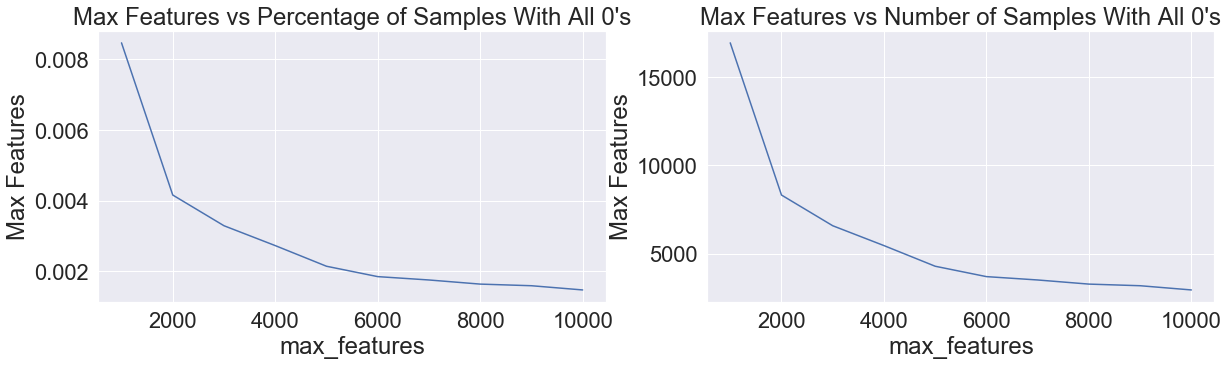

In [5]:
missing_features1["samples_with_no_features_percentage"] = missing_features1["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features1, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Max Features vs Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Max Features")
_ = sns.lineplot(data = missing_features1, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Max Features vs Number of Samples With All 0's")
_ = a[1].set_ylabel("Max Features")

In [6]:
MAX_FEATURES1 = 3000

In [7]:
cv1 = CountVectorizer(ngram_range=(1,1), max_features=MAX_FEATURES1)
X1 = cv1.fit_transform(corpus["review_body"].array)

In [8]:
len(cv1.get_feature_names())

3000

In [9]:
np.shape(X1)

(2000000, 3000)

### Word Occurences

In [10]:
count_df1 = pd.DataFrame(np.transpose(np.sum(X1, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df1.describe()

,gram_occurence
count,3.000000e+03
mean,1.586957e+04
std,5.420259e+04
min,1.207000e+03
25%,2.093500e+03
50%,4.177000e+03
75%,1.114375e+04
max,1.558067e+06


### Top unigram occurence

               bin  gram_occurence_percent
0         (0, 100]                0.000000
1       (100, 500]                0.000000
2      (500, 1000]                0.000000
3     (1000, 2000]               23.066667
4  (2000, 1558067]               76.933333


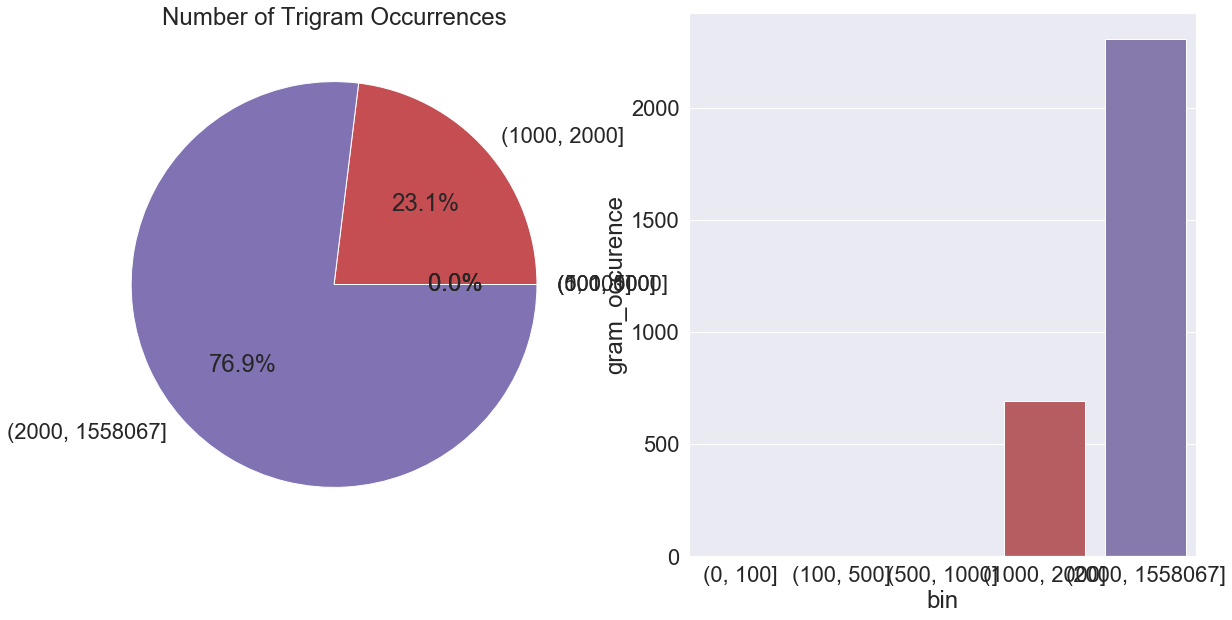

In [11]:
bins1 = count_df1.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 100, 500, 1000, 2000, x["gram_occurence"].max()]))
bins1 = pd.DataFrame(bins1.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins1["gram_occurence_percent"] = bins1["gram_occurence"] / bins1["gram_occurence"].sum() * 100

print(bins1[["bin", "gram_occurence_percent"]])

f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(bins1.gram_occurence_percent, labels=bins1.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Trigram Occurrences")

_ = sns.barplot(data = bins1, x= "bin", y="gram_occurence", ax=a[1])

10 most frequently occuring words in our features

In [12]:
top1 = count_df1.sort_values("gram_occurence", ascending=False)
np.take(cv1.get_feature_names(), top1.head(20).index.tolist())


array(['not', 'phone', 'case', 'great', 'very', 'one', 'work', 'would',
       'good', 'like', 'product', 'will', 'do', 'fit', 'screen', 'doe',
       'use', 'ti', 'well', 'get'], dtype='<U14')

10 most infrequest words in our features

In [13]:
np.take(cv1.get_feature_names(), top1.tail(20).index.tolist())


array(['becoming', 'assemble', 'maxboost', 'upright', 'haha', 'longevity',
       'supposedly', 'clicking', 'caution', 'jambox', 'centered', 'habit',
       'instant', 'pleasing', 'atrix', 'assist', 'nightstand', 'refused',
       'travelling', 'log'], dtype='<U14')

# Bigram

* Even at around 10k features, we will have about 7% of samples without any features - using bigram alone will not meet our 1% criteria

In [14]:
missing_features2 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(2,2), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features2 = missing_features2.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 298436
Number of rows without features using max_features 2000: 238767
Number of rows without features using max_features 3000: 212873
Number of rows without features using max_features 4000: 197132
Number of rows without features using max_features 5000: 186298
Number of rows without features using max_features 6000: 177582
Number of rows without features using max_features 7000: 169484
Number of rows without features using max_features 8000: 164196
Number of rows without features using max_features 9000: 159275
Number of rows without features using max_features 10000: 155381


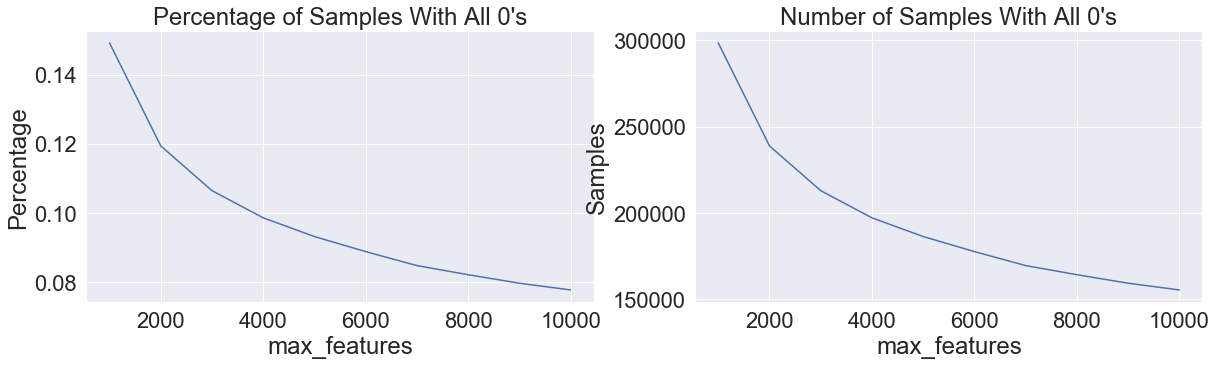

In [68]:
missing_features2["samples_with_no_features_percentage"] = missing_features2["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features2, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Percentage")

_ = sns.lineplot(data = missing_features2, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Number of Samples With All 0's")
_ = a[1].set_ylabel("Samples")

In [16]:
MAX_FEATURES2 = 4000

In [17]:
cv2 = CountVectorizer(ngram_range=(2,2), max_features=MAX_FEATURES2)
X2 = cv2.fit_transform(corpus["review_body"].array)

In [18]:
len(cv2.get_feature_names())

4000

In [19]:
np.shape(X2)

(2000000, 4000)

### Word Count

In [20]:
count_df2 = pd.DataFrame(np.transpose(np.sum(X2, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df2.describe()

,gram_occurence
count,4000.000000
mean,3283.798250
std,8321.147347
min,1035.000000
25%,1298.750000
50%,1757.500000
75%,2865.000000
max,224783.000000


10 most frequently occuring bigram

In [21]:
count_df2 = count_df2.sort_values("gram_occurence", ascending=False)
np.take(cv2.get_feature_names(), count_df2.head(20).index.tolist())

array(['do not', 'ti ame', 'doe not', 'did not', 'screen protector',
       'can not', 'work great', 'will not', 'ti ames', 'would not',
       'not work', 'phone case', 'great product', 'not fit', 'very good',
       'work well', 'very well', 'fit phone', 'would recommend',
       'could not'], dtype='<U20')

10 most infrequently occuring bigram

In [22]:
np.take(cv2.get_feature_names(), count_df2.tail(20).index.tolist())

array(['bought friend', 'good design', 'hour later', 'month very',
       'phone long', 'pair headphone', 'not function', 'look not',
       'fit snuggly', 'button covered', 'cheap work', 'looking new',
       'take photo', 'phone service', 'contact seller', 'cup mount',
       'not loose', 'better old', 'perfect very', 'love able'],
      dtype='<U20')

# Trigram

* if we use all 10k trigrams we would still have >35% samples without any features -> trigram alone as features is not a viable solution
* however, trigrams are interesting because you start getting phrases like 'do not work', 'does not fit', etc
* perhaps combining trigram with other grams would be better

In [23]:
missing_features3 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 2000):
    cv = CountVectorizer(ngram_range=(3,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features3 = missing_features3.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 1104147
Number of rows without features using max_features 3000: 899324
Number of rows without features using max_features 5000: 807582
Number of rows without features using max_features 7000: 750431
Number of rows without features using max_features 9000: 709358


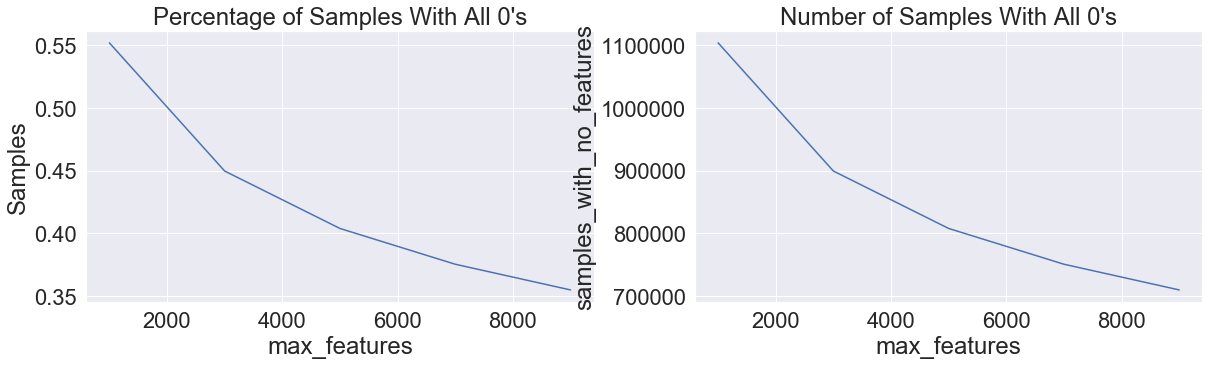

In [67]:
missing_features3["samples_with_no_features_percentage"] = missing_features3["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features3, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Percentage")

_ = sns.lineplot(data = missing_features3, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Number of Samples With All 0's")
_ = a[0].set_ylabel("Samples")


In [25]:
MAX_FEATURES3 = 10000

In [26]:
cv3 = CountVectorizer(ngram_range=(3,3), max_features=MAX_FEATURES3)
X3 = cv3.fit_transform(corpus["review_body"].array)

In [27]:
len(cv3.get_feature_names())

10000

In [28]:
np.shape(X3)

(2000000, 10000)

### Word Count

In [29]:
count_df3 = pd.DataFrame(np.transpose(np.sum(X3, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df3.describe()

,gram_occurence
count,10000.000000
mean,443.342300
std,835.526419
min,151.000000
25%,187.000000
50%,247.000000
75%,401.000000
max,24245.000000


10 most frequently occuring trigram

In [30]:
count_df3 = count_df3.sort_values("gram_occurence", ascending=False)
np.take(cv3.get_feature_names(), count_df3.head(20).index.tolist())

array(['doe not work', 'did not work', 'doe not fit', 'do not buy',
       'do not know', 'did not fit', 'first ti ame', 'long ti ame',
       'case doe not', 'do not like', 'would not recommend',
       'every ti ame', 'work very well', 'phone doe not',
       'several ti ames', 'do not want', 'fit phone perfectly',
       'can not beat', 'not fit phone', 'do not think'], dtype='<U29')

10 most infrequently occuring trigram

In [31]:
np.take(cv3.get_feature_names(), count_df3.tail(20).index.tolist())

array(['would say case', 'battery life decent', 'nice quality case',
       'do not connect', 'never worry phone', 'read review buying',
       'screen very good', 'change look phone',
       'perfectly screen protector', 'love case make', 'one look great',
       'amazon would not', 'first cell phone', 'sli enough fit',
       'holster do not', 'sent wrong color', 'charging cable not',
       'will not damage', 'one best feature', 'usb powered device'],
      dtype='<U29')

### Word Occurences

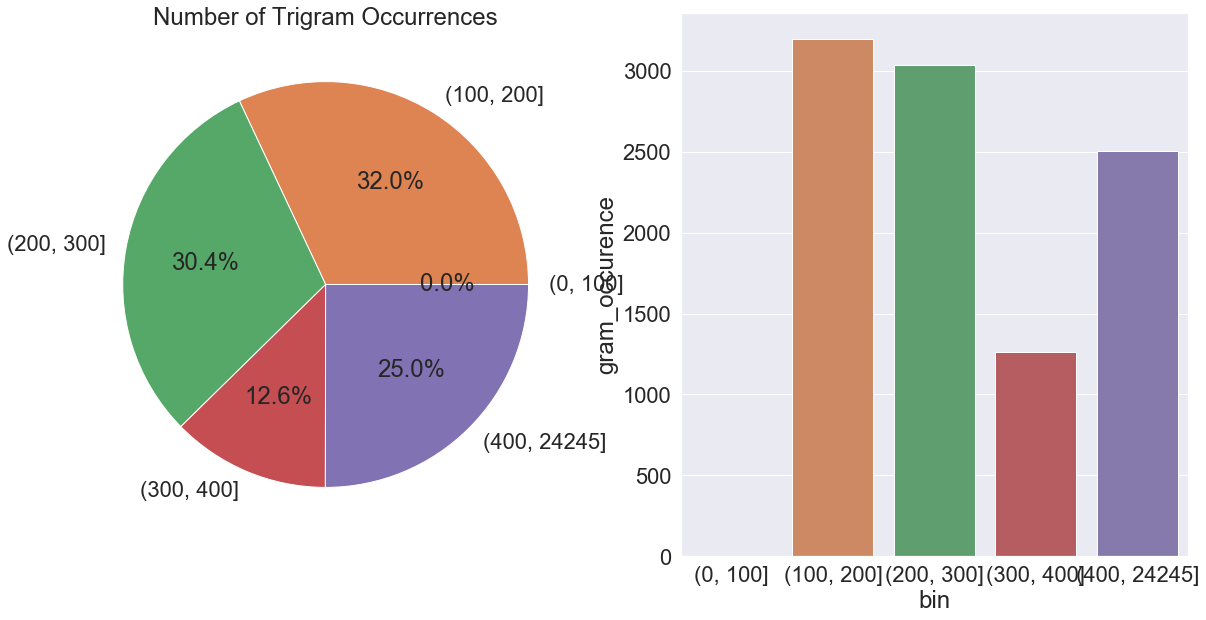

In [32]:
bins3 = count_df3.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 100, 200, 300, 400, x["gram_occurence"].max()]))
bins3 = pd.DataFrame(bins3.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins3["gram_occurence_percent"] = bins3["gram_occurence"] / bins3["gram_occurence"].sum() * 100

bins3[["bin", "gram_occurence_percent"]]

f, a = plt.subplots(1, 2, figsize=(20, 10))
_ = a[0].pie(bins3.gram_occurence_percent, labels=bins3.bin, autopct='%1.1f%%')
_ = a[0].set_title("Number of Trigram Occurrences")

_ = sns.barplot(data = bins3, x= "bin", y="gram_occurence", ax=a[1])

### very few trigrams occur more than 50 times in the corpus

In [33]:
count_df3[count_df3 > 500].count()

gram_occurence    1824
dtype: int64

# Bigram + Trigram

* With bigram + trigram - at 10k features, we would still have about 8% samples with all 0 features. Again this does not meet our criteria
* when we use bigram + trigram - increasing the number of features beyond 7500 does not really help reduce number of reviews without features.

In [34]:
missing_features23 = pd.DataFrame()
for max_features in np.arange(1000, 10001, 2000):
    cv = CountVectorizer(ngram_range=(2,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features23 = missing_features23.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 310367
Number of rows without features using max_features 3000: 221790
Number of rows without features using max_features 5000: 193840
Number of rows without features using max_features 7000: 177798
Number of rows without features using max_features 9000: 166006


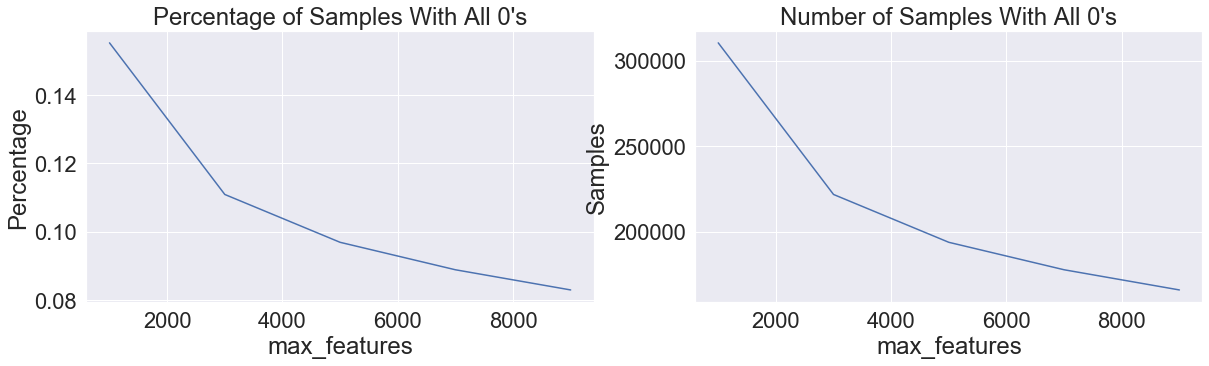

In [66]:
missing_features23["samples_with_no_features_percentage"] = missing_features23["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features23, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Percentage")

_ = sns.lineplot(data = missing_features23, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Number of Samples With All 0's")
_ = a[1].set_ylabel("Samples")


# Unigram + Bigram + Trigram

* with 4k features, we only have about .4% samples that does not contain any of the unigrams, bigrams, or trigrams
* There is a dropoff at around 4k max features where creating more features doesn't necessarily decrease the number of samples without features that much - at most we should be creating 4000 max features


In [36]:
missing_features = pd.DataFrame()
for max_features in np.arange(1000, 10001, 1000):
    cv = CountVectorizer(ngram_range=(1,3), max_features=max_features)
    X = cv.fit_transform(corpus["review_body"].array)
    missing = len(np.where(~X.toarray().any(axis=1))[0])
    d = {
        "max_features": max_features,
        "samples_with_no_features": missing
    }
    missing_features = missing_features.append(d, ignore_index=True)
    print(f'Number of rows without features using max_features {max_features}: {missing}')

Number of rows without features using max_features 1000: 17970
Number of rows without features using max_features 2000: 11956
Number of rows without features using max_features 3000: 10904
Number of rows without features using max_features 4000: 7898
Number of rows without features using max_features 5000: 7362
Number of rows without features using max_features 6000: 7205
Number of rows without features using max_features 7000: 6565
Number of rows without features using max_features 8000: 5832
Number of rows without features using max_features 9000: 5730
Number of rows without features using max_features 10000: 5635


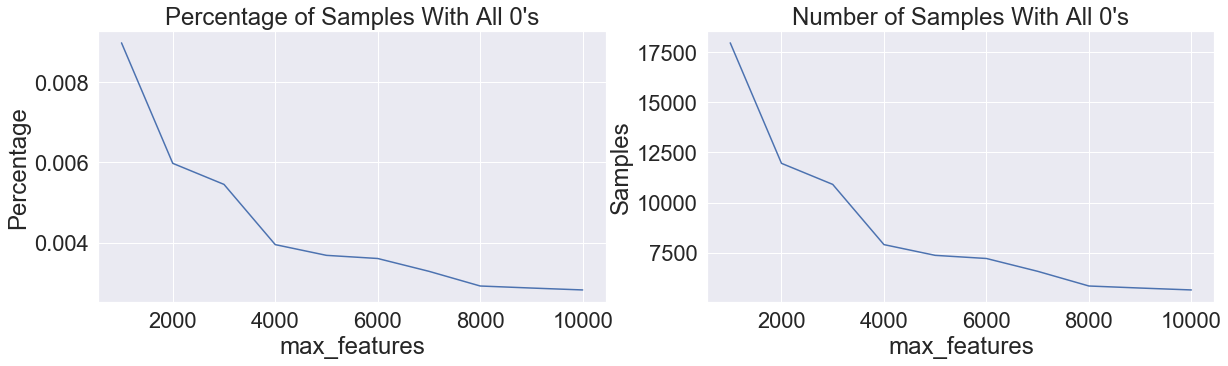

In [64]:
missing_features["samples_with_no_features_percentage"] = missing_features["samples_with_no_features"] / len(corpus)

f, a = plt.subplots(1, 2, figsize=(20, 5))
_ = sns.lineplot(data = missing_features, x = "max_features", y = "samples_with_no_features_percentage", ax=a[0])
_ = a[0].set_title("Percentage of Samples With All 0's")
_ = a[0].set_ylabel("Percentage")

_ = sns.lineplot(data = missing_features, x = "max_features", y = "samples_with_no_features", ax=a[1])
_ = a[1].set_title("Number of Samples With All 0's")
_ = a[1].set_ylabel("Samples")


In [38]:
MAX_FEATURE13=4000

In [39]:
cv13 = CountVectorizer(ngram_range=(1,3), max_features=MAX_FEATURE13)
X13 = cv13.fit_transform(corpus["review_body"].array)

In [40]:
len(cv13.get_feature_names())

4000

In [41]:
np.shape(X13)

(2000000, 4000)

In [42]:
X13.toarray()[:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Word Occurences

In [43]:
count_df13 = pd.DataFrame(np.transpose(np.sum(X13, axis=0))).rename({0:"gram_occurence"}, axis=1)
count_df13.describe()

,gram_occurence
count,4.000000e+03
mean,1.423773e+04
std,4.763749e+04
min,2.120000e+03
25%,2.883000e+03
50%,4.584500e+03
75%,9.951500e+03
max,1.558067e+06


10 most frequently occuring words in our corpus

In [45]:
top_idx13 = count_df13.sort_values("gram_occurence", ascending=False)
np.take(cv13.get_feature_names(), top_idx13.head(20).index.tolist())


array(['not', 'phone', 'case', 'great', 'very', 'one', 'work', 'would',
       'good', 'like', 'product', 'will', 'do', 'fit', 'screen', 'doe',
       'use', 'ti', 'well', 'get'], dtype='<U26')

10 most infrequent unigram to trigram

In [47]:
np.take(cv13.get_feature_names(), top_idx13.tail(20).index.tolist())


array(['phone keep', 'protector fit', 'power supply', 'case keep',
       'item work', 'one worked', 'scanner', 'used case', 'incoming',
       'not hesitate', 'break easily', 'glad bought', 'motion',
       'back pocket', 'not buy product', 'stay away', 'knife',
       'case sturdy', 'quick delivery', 'suddenly'], dtype='<U26')

### Top unigram, bigram and trigram occurence

                bin  gram_occurence_percent
0         (0, 2000]                   0.000
1      (2000, 4000]                  43.825
2      (4000, 8000]                  25.600
3     (8000, 16000]                  14.850
4    (16000, 32000]                   7.875
5  (32000, 1558067]                   7.850


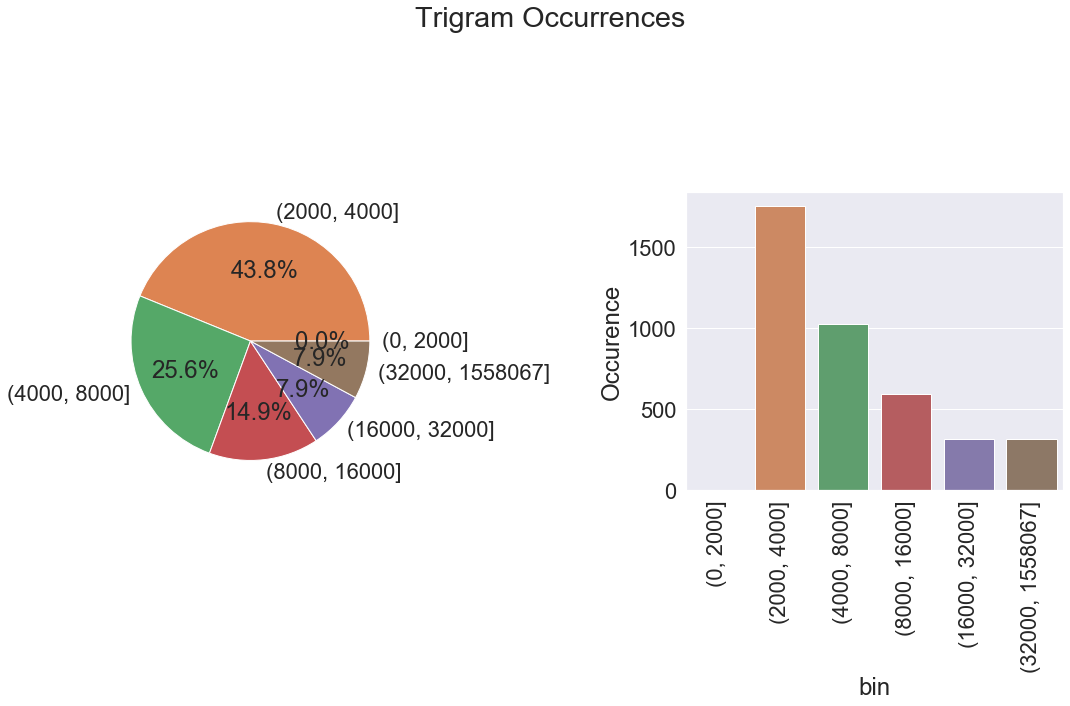

In [62]:
top_count13 = count_df13.sort_values("gram_occurence", ascending=False)
bins_13 = top_count13.assign(bin=lambda x: pd.cut(x["gram_occurence"], [0, 2000, 4000, 8000, 16000, 32000, x["gram_occurence"].max()]))
bins_13 = pd.DataFrame(bins_13.groupby("bin").size(), columns=["gram_occurence"]).reset_index()
bins_13["gram_occurence_percent"] = bins_13["gram_occurence"] / bins_13["gram_occurence"].sum() * 100

print(bins_13[["bin", "gram_occurence_percent"]])

f, a = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout(pad = 8.0)
_ = f.suptitle("Trigram Occurrences")
_ = a[0].pie(bins_13.gram_occurence_percent, labels=bins_13.bin, autopct='%1.1f%%')

_ = sns.barplot(data = bins_13, x= "bin", y="gram_occurence", ax=a[1])
_ = a[1].set_ylabel("Occurence")
_ = plt.xticks(rotation = 90)

In [49]:
ngrams_df13 = pd.concat([pd.DataFrame(np.take(cv13.get_feature_names(), top_count13.index.tolist())),
                         top_count13["gram_occurence"].reset_index(drop=True)], axis=1).rename({0:"grams"}, axis=1)
ngrams_df13.head()

,grams,gram_occurence
0,not,1558067
1,phone,1109166
2,case,971453
3,great,556766
4,very,529060


### Distribution of unigram, bigram vs trigram in list

   word_count  word_count_occurence
0           1                  2232
1           2                  1546
2           3                   222
   word_count  word_count_occurence  word_count_percent
0           1                  2232               55.80
1           2                  1546               38.65
2           3                   222                5.55


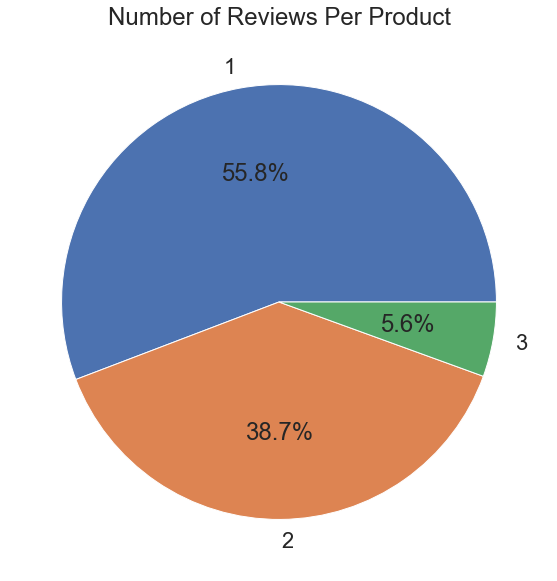

In [50]:
ngrams_df13["word_count"] = ngrams_df13.grams.str.split(" ").str.len()
top_13 = ngrams_df13[["word_count", "grams"]].groupby("word_count").count().reset_index().rename({"grams":"word_count_occurence"}, axis=1)
print(top_13)

top_13["word_count_percent"] = top_13["word_count_occurence"] / top_13["word_count_occurence"].sum() * 100
print(top_13)

f, a = plt.subplots(1, 1, figsize=(10, 10))
_ = plt.pie(top_13.word_count_percent, labels=top_13.word_count, autopct='%1.1f%%')
_ = plt.title("Number of Reviews Per Product")

### Let's Make Sure We Have Missing Features for all Star Ratings

Once we create our features, there are reviews that do not have any features at all. For these, we will be removing them from our dataset. We want to make sure that these reviews without features covers all star ratings.

* distribution is not exactly the same as original but there does all star ratings have missing features
* 5 star ratings seems to have the most with missing features - this is OK since we also have the most number of reviews with 5-star ratings

In [51]:
missing_idx = np.where(~X13.toarray().any(axis=1))[0]

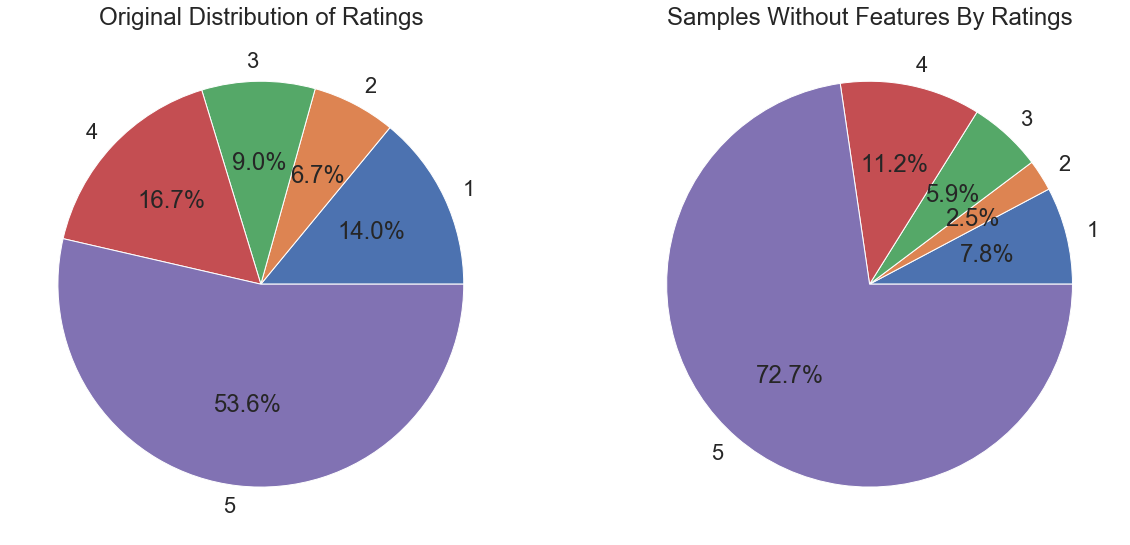

In [52]:
f, a = plt.subplots(1, 2, figsize=(20, 10))


original_dist = pd.DataFrame(corpus.groupby("star_rating").size(), columns=["count"]).reset_index()
original_dist["percent"] = original_dist["count"] / original_dist["count"].sum() * 100
_ = a[0].pie(original_dist.percent, labels=original_dist.star_rating, autopct='%1.1f%%')
_ = a[0].set_title("Original Distribution of Ratings")


missing_dist = corpus.iloc[missing_idx.tolist()][["star_rating", "review_body"]].\
                groupby("star_rating").count().rename({"review_body": "count"}, axis=1).reset_index()
missing_dist["percent"] = missing_dist["count"] / missing_dist["count"].sum() * 100
_ = a[1].pie(missing_dist.percent, labels=missing_dist.star_rating, autopct='%1.1f%%')
_ = a[1].set_title("Samples Without Features By Ratings")

